In [1]:
# import tensorflow
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import mglearn
from sklearn.svm import SVC
from sklearn import metrics
from skimage.transform import resize
import random
import string

C:\Users\vuanh\AppData\Local\Temp\ipykernel_19340\149711296.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


##### Load data

['colorImages', 'boundingBox', 'landmarks2D', 'landmarks3D']
(231, 237, 3, 79)
(4, 2, 79)
(68, 2, 79)
(68, 3, 79)
(79, 231, 237, 3)


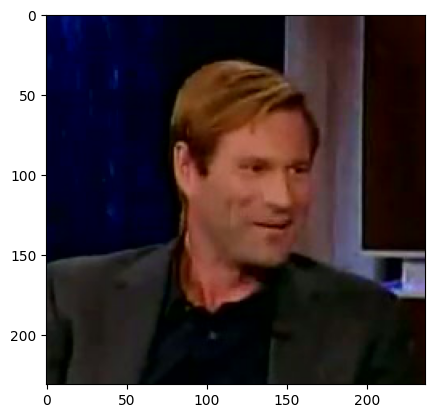

In [2]:
data_test = np.load('./data_youtube/youtube_faces_with_keypoints_full_1/youtube_faces_with_keypoints_full_1/Aaron_Eckhart_0.npz')
print(data_test.files)
print(data_test['colorImages'].shape)
print(data_test['boundingBox'].shape)
print(data_test['landmarks2D'].shape)
print(data_test['landmarks3D'].shape)

x = data_test['colorImages']
if x.shape[2] == 3:
    x = np.rollaxis(x,3) # roll the axis to make it (231, 237, 3, 79) instead of (79, 231, 237, 3)
print(x.shape)
plt.imshow(x[78])

544
x shape is  (79, 231, 237, 3)
1
x shape is  (43, 179, 144, 3)
x shape is  (43, 326, 291, 3)
2
x shape is  (78, 233, 233, 3)
x shape is  (97, 270, 312, 3)
3


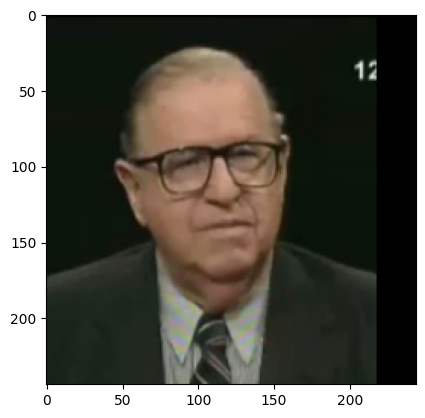

In [3]:
path = './data_youtube/youtube_faces_with_keypoints_full_1/youtube_faces_with_keypoints_full_1/'

def save_image(images,labels):
    path = f'./data_youtube/data_images/{labels}'
    try:
        os.mkdir(path)
    except:
        pass
    for i in range(images.shape[0]):
        name = "".join(random.choices(string.ascii_uppercase + string.digits, k=10))
        # print(images[i])
        plt.imsave(f'{path}/{name}.png', images[i])
        

def load_data(path):
    cnt = 0
    print(len(os.listdir(path)))
    data = np.zeros((0, 244, 244, 3))
    labels = np.zeros((0, 1))
    name_old = ''
    for file in os.listdir(path):
        name = file.split('_')[0]
        if file.endswith('.npz'):
            data_test = np.load(path + file)
            x = data_test['colorImages']
            if x.shape[2] == 3:
                x = np.rollaxis(x,3) # roll the axis to make it (231, 237, 3, 79) instead of (79, 231, 237, 3)
            elif data_test["colorImages"].shape[1] == 3:
                x = np.rollaxis(data_test["colorImages"], 2)
            elif data_test["colorImages"].shape[0] == 3:
                x = np.rollaxis(data_test["colorImages"], 1)
            
            print("x shape is ", x.shape)
            x = resize(x, (x.shape[0],x.shape[1] * 244/(max(x.shape[1],x.shape[2])),x.shape[2] * 244/(max(x.shape[1],x.shape[2]))))
            # print("x shape is ", x.shape)
            x = x[:min(20, x.shape[0]),:,:,:] # take the first 200 frames
            # print("x shape is ", x.shape)
            x_train = np.zeros((x.shape[0], 244, 244, 3))
            x_train[:, :x.shape[1], :x.shape[2], :] = x
            # print("x_train shape is ", x_train.shape)
            data = np.append(data, x_train)
            data = data.reshape(-1, 244, 244, 3)
            # print("data shape is ", data.shape)
            save_image(x , name)
            if name != name_old:
                cnt += 1
                print(cnt)
                name_old = name
                
            labels = np.append(labels,np.full((x_train.shape[0], 1), cnt))
            if cnt == 3:
                break
    return data,labels

data,labels = load_data(path)
plt.imshow(data[40])
# save_image(data , "name")

In [4]:
print(data.shape)
print(labels.shape)
print(np.unique(labels))
print(labels[50:100])

(100, 244, 244, 3)
(100,)
[1. 2. 3.]
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3.]


In [5]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_base_nerwork(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    return Model(inputs, x)
    
def triplet_loss(inputs, dist='euclidean', margin='maxplus'):
    anchor, positive, negative = inputs
    positive_distance = tf.square(anchor - positive)
    negative_distance = tf.square(anchor - negative)
    """_summary_
        distance between two vectors with euclidean distance
    Example:
    v=(1,0,5)
    w=(0,2,4)
    => d(v,w)=sqrt((1-0)^2+(0-2)^2+(5-4)^2=sqrt(1^2+(-2)^2+1^2)=sqrt(1+4+1)=√6
    """
    if dist == 'euclidean':
        positive_distance = tf.sqrt(tf.reduce_sum(positive_distance, axis=-1, keepdims=True) + 1e-16)
        negative_distance = tf.sqrt(tf.reduce_sum(negative_distance, axis=-1, keepdims=True) + 1e-16)
    elif dist == 'sqeuclidean':
        positive_distance = tf.reduce_sum(positive_distance, axis=-1, keepdims=True)
        negative_distance = tf.reduce_sum(negative_distance, axis=-1, keepdims=True)
    loss = positive_distance - negative_distance
    # print(loss)
    if margin == 'maxplus':
        loss = tf.maximum(0.0, 2 + loss)
    elif margin == 'softplus':
        loss = tf.keras.backend.log(1 + tf.exp(loss))
    return tf.reduce_mean(loss)

def create_siamese_network(input_shape, base_network):
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)
    input_c = Input(shape=input_shape)
    
    processed_a = base_network(input_a)
    processed_b = base_network(input_b)
    processed_c = base_network(input_c)
    
    distance = triplet_loss([processed_a, processed_b, processed_c], dist='euclidean', margin='softplus')
    # distance = triplet_loss([processed_a, processed_b, processed_c], dist='euclidean', margin='maxplus')
    network = Model([input_a, input_b, input_c], distance)
    return network

input_shape = (244, 244, 3)
base_network = create_base_nerwork(input_shape)
siamese_network = create_siamese_network(input_shape, base_network)
siamese_network.compile(loss='mse', optimizer='adam')
siamese_network.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 244, 244, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 244, 244, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 244, 244, 3  0           []                               
                                )]                                                          

In [20]:
def prepare_data_for_siamese(x_train, y_train):
    triplets = []
    num_classes = len(np.unique(y_train))
    print('num_classes:', num_classes)
    labels = []
    for _ in range(1,num_classes+1):
        # select anchor
        anchor_class = _
        negative_class = anchor_class
        
        # select double
        indices = np.where(y_train == anchor_class)[0]
        # print('indices:', indices)
        for i in indices:
            anchor_idx = i
            positive_idx = np.random.choice(indices)
            while positive_idx == anchor_idx:
                positive_idx = np.random.choice(indices)
                
            while negative_class == anchor_class:
                negative_class = np.random.randint(0, num_classes)
            # print(negative_class)
            negative_indices = np.where(y_train == negative_class)[0]
            # print('negative_indices:', negative_indices)
            for negative_idx in negative_indices:
                triplets.append([x_train[anchor_idx], x_train[positive_idx], x_train[negative_idx]])
                labels.append([anchor_idx, positive_idx, negative_idx])
        # negative_idx = np.random.choice(negative_indices)
        # triplets.append([x_train[anchor_idx], x_train[positive_idx], x_train[negative_idx]])
    return np.array(triplets), np.array(labels)

triplets,l = prepare_data_for_siamese(data, labels)
# print('triplets shape:', triplets.shape)
# print('labels:', l[110:450])

num_classes: 3


In [21]:
print('triplets shape:', triplets.shape)
# print('labels:', l[110:450])
la = pd.DataFrame(l)

la.to_csv('./models/labels.csv', index=False)

triplets shape: (2400, 3, 244, 244, 3)


In [8]:
y = np.zeros((triplets.shape[0], 1))
x_train, x_test, y_train, y_test = train_test_split(triplets, y, test_size=0.2, random_state=42)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (1280, 3, 244, 244, 3)
x_test shape: (320, 3, 244, 244, 3)


In [9]:
siamese_network.fit([x_train[:, 0], x_train[:, 1], x_train[:, 2]], y_train, batch_size=32, epochs=100, verbose=1,validation_data=([x_test[:, 0], x_test[:, 1], x_test[:, 2]], y_test))
# siamese_network.fit([triplets[:, 0], triplets[:, 1], triplets[:, 2]], np.zeros((triplets.shape[0], 1)), batch_size=32, epochs=100, verbose=1)

Epoch 1/100
40/40 [==============================] - 8s 99ms/step - loss: 0.0096 - val_loss: 0.0000e+00
Epoch 2/100
40/40 [==============================] - 3s 84ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/100
40/40 [==============================] - 3s 84ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/100
40/40 [==============================] - 3s 84ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/100
40/40 [==============================] - 3s 84ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/100
40/40 [==============================] - 3s 85ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/100
40/40 [==============================] - 3s 86ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 8/100
40/40 [==============================] - 3s 85ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/100
40/40 [==============================] - 3s 85ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 10/100
40/40 [============

In [10]:
base_network.save('./models/base_network.h5')

In [16]:
print(data[0].shape)
x = data[32]
x = np.reshape(x, (1, 244, 244, 3))
yhat1 = base_network.predict(x)

x = data[41]
x = np.reshape(x, (1, 244, 244, 3))
yhat2 = base_network.predict(x)

x = data[0]
x = np.reshape(x, (1, 244, 244, 3))
yhat3 = base_network.predict(x)

(244, 244, 3)
1/1 [==============================] - 0s 13ms/step


In [17]:
def distance(yhat1, yhat2):
    return np.sqrt(np.sum(np.square(yhat1 - yhat2)))

print(distance(yhat1, yhat2))
print(distance(yhat1, yhat3))

172.8941
227.12141
